# Homework - week 4

## Libraries

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error, auc, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge

## Data import

In [145]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv')
data.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.67,4.52,0.03,124.98,yes,no,3,54,1,12
1,yes,0,33.25,2.42,0.01,9.85,no,no,3,34,1,13
2,yes,0,33.67,4.50,0.00,15.00,yes,no,4,58,1,5
3,yes,0,30.50,2.54,0.07,137.87,no,no,0,25,1,7
4,yes,0,32.17,9.79,0.07,546.50,yes,no,2,64,1,5


## Preparation

In [146]:
data.card.value_counts()

yes    1023
no      296
Name: card, dtype: int64

In [147]:
data.card = (data.card == 'yes').astype(int)
data.card.value_counts()

1    1023
0     296
Name: card, dtype: int64

In [148]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

## Question 1

In [149]:
df_train.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
1105,0,3,40.50,4.01,0.00,0.00,no,no,1,12,1,17
431,0,1,32.33,6.00,0.00,0.00,yes,no,4,18,1,4
407,1,1,29.17,2.20,0.04,69.79,no,no,0,49,1,7
1217,1,1,54.67,7.29,0.11,647.21,yes,no,2,78,1,9
1133,1,0,25.00,3.40,0.00,0.00,yes,no,2,29,0,4


In [150]:
cols = list((df_train).columns)
numerical = df_train.select_dtypes(include=['int64', 'float64']).drop('card', axis=1).columns
categorical = [i for i in cols if i not in numerical]

In [151]:
scores = []
for col in numerical:
    score = roc_auc_score(df_train.card, df_train[col])
    if score < 0.5:
        score = roc_auc_score(df_train.card, -df_train[col])
    else:
        pass
    scores.append(score)

pd.Series(dict(zip(numerical,scores))).sort_values(ascending=False)

expenditure   0.99
share         0.99
reports       0.72
active        0.60
income        0.59
majorcards    0.53
dependents    0.53
months        0.53
age           0.52
dtype: float64

## Question 2

In [152]:
def preprocess(data):
    selected_cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp", 'card']
    data = data[selected_cols].copy()

    data.card = (data.card == 'yes').astype(int)

    df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.card.values
    y_val = df_val.card.values
    y_test = df_test.card.values

    del df_train['card']
    del df_val['card']
    del df_test['card']

    return df_train, df_val, df_test, y_train, y_val, y_test
    
def vectorize(df):

    dv = DictVectorizer(sparse=False)

    dict = df.to_dict(orient='records')
    X = dv.fit_transform(dict)

    return X, dv

def train_model(df_train, y_train, C=1):
    X_train, dv = vectorize(df_train)
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    return model, dv

def predict_model(df, dv, model):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [153]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv')
df_train, df_val, df_test, y_train, y_val, y_test = preprocess(data)
model, dv = train_model(df_train, y_train)
y_pred = predict_model(df_val, dv, model)
print(roc_auc_score(y_val,y_pred).round(3))

0.995


## Question 3

In [154]:
def scores(y_val,y_pred):
    scores = []

    # Creating an array of evenly-spaced probabilities from 0 to 1 (aka 0, 0.1, 0.2, ..., 0.99, 1)
    thresholds = np.linspace(0, 1, 101)

    # Printing true positives & negatives, false positives & negatives for each rate 
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        # List of tuples is created per threshold
        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['recall'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

<AxesSubplot:xlabel='threshold'>

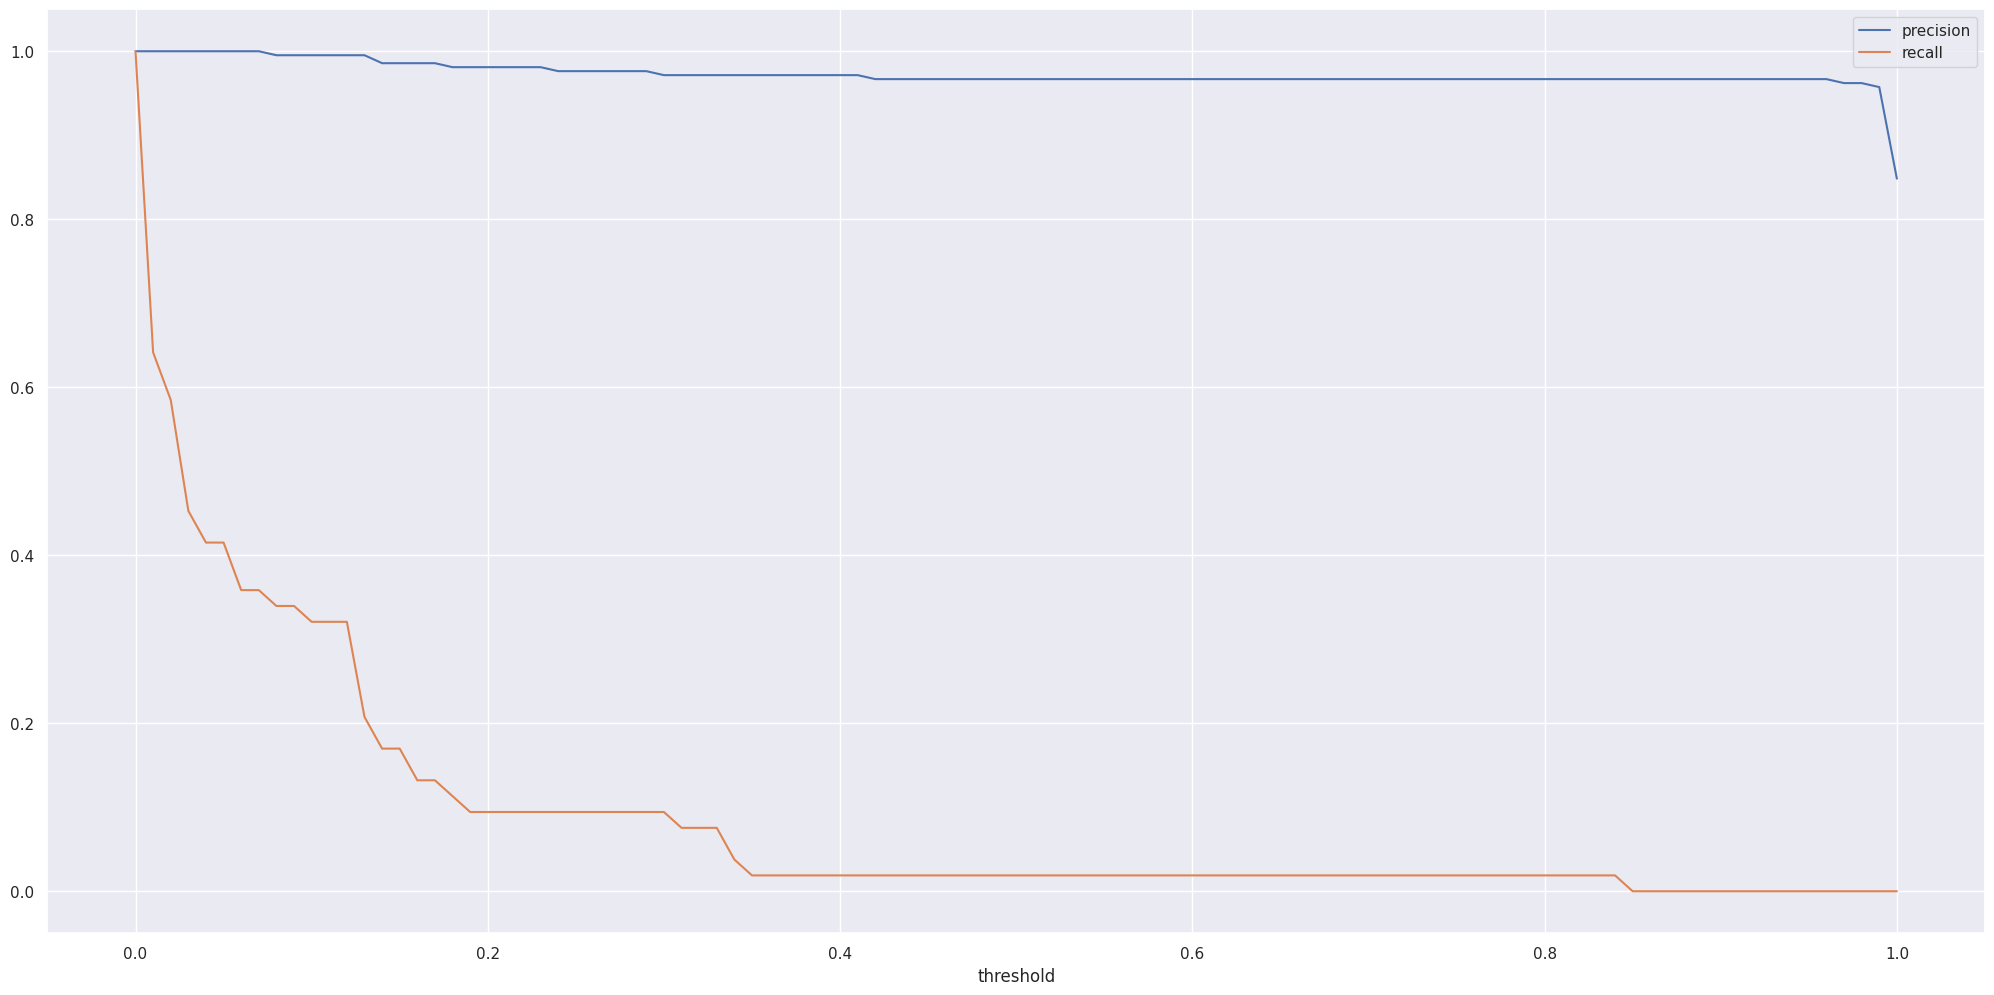

In [155]:
tresh = np.linspace(0,1,101)
df_scores = scores(y_val, y_pred)
df_scores[['threshold','precision','recall']].plot(x='threshold')